# Running Computational Alchemy for Catalysis: Binding Energy Predictions
This notebook outlines Python functions that use information from VASP calculations to predict descriptors for hypothetical catalyst. These functions utilize tools from the Atomic Simulation Environment (ASE) to manipulate catalyst surface models and perform calculations with computational alchemy.

In this example, we apply computational alchemy on reference calculcations of H binding on Pt(111) to predict binding energies (BEs) of H on hypothetical alloys of Pt(111).

This package can be installed through pip using the following command:

`pip install git+https://github.com/KeithLabPitt/comp_alchemy.git`

In [42]:
from phystone import alchemy, benchmark, elec_stat_pot
import numpy as np
import pandas as pd

Here we create an Alchemy object with the `Alchemy()` class. The only inputs needed are the paths to VASP calculations of the slab and the slab with the adsorbate, respectively. Both of these directories must contain files of completed VASP calculations. Particularly, this class needs to read the POSCAR, CONTCAR, OSZICAR, and OUTCAR. 

In [43]:
h_pt = alchemy.Alchemy('Pt-slab-2x2/','Pt-slab-2x2-H-ontop/')

An Alchemy object has several attributes defined initially. Below we can obtain ASE Atoms objects of the POSCAR and CONTCAR for the bare slab (`slab`,`slab_contcar`) and the slab with an adsorbate (`ads`,`ads_contcar`) for visualization or other manipulations. 

In [44]:
slab = h_pt.slab
ads = h_pt.ads

slab_contcar = h_pt.slab_contcar
ads_contcar = h_pt.ads_contcar

## Calculating alchemical potentials
The `Alchemy()` class also grabs the atom-centered electrostatic potential (ESP) from the OUTCAR files for slab and ads (`Alchemy().slab_esp` and `Alchemy().ads_esp`). The ESP differences are then calculated between ads and slab (`Alchemy().esp_diff`), giving us the alchemical potential that are used to make predictions with Alchemy. These are all printed below.

In [45]:
print(f'''
Atom-centered electrostatic potentials:
Slab:
{h_pt.slab_esp}

Ads:
{h_pt.ads_esp}

Differences in electrostatic potentials between ads and slab
{np.round(h_pt.esp_diff,4)}''')


Atom-centered electrostatic potentials:
Slab:
[-74.4101, -74.4101, -74.4101, -74.4101, -74.8774, -74.8774, -74.8774, -74.8774, -74.8682, -74.8682, -74.8682, -74.8682, -74.3933, -74.3933, -74.3933, -74.3933]

Ads:
[-74.2705, -74.2908, -74.2908, -74.2908, -74.777, -74.777, -74.777, -74.6489, -74.7431, -74.7626, -74.7431, -74.7431, -74.7717, -74.3295, -74.3295, -74.3295, -37.4665]

Differences in electrostatic potentials between ads and slab
[ 0.1396  0.1193  0.1193  0.1193  0.1004  0.1004  0.1004  0.2285  0.1251
  0.1056  0.1251  0.1251 -0.3784  0.0638  0.0638  0.0638]


### Visualizing alchemical derivatives
With the `heatmap()` function, visualize the alchemical derivatives with ASE GUI by running the cell below, pressing "c" in ASE GUI, and under "Choose how the atoms are colored:" selecting "By initial charge." You may need to uncomment `view(slab_vis)`. 

In [46]:
from ase.visualize import view
slab_vis = elec_stat_pot.heatmap(slab,h_pt.esp_diff)
#view(slab_vis)

## Doing Alchemy:
### Making hypothetical materials with alchemical transmutations and calculating alchemical derivatives
Now that an `Alchemy()` object has been created, we can do alchemy with it. The `Alchemy().do_alchemy()` method produces a Pandas DataFrame with information about systems we create and their predicted alchemical derivatives. So how can we control what systems we create? The inputs to this method allow us to customize how we explore materials. 

The main constraints that must be taken into consideration is that for every atom transmuted at the surface (top) of the slab model by some nuclear charge change ($\Delta Z$), we must perform a counter transmutation of the opposite nuclear charge change ($-\Delta Z$) to make our overall change isoelectronic. 

With that, here is how the inputs should be specified:

`delta_nuclear_charge` : How much the nuclear charge changes when transmuting an atom in the reference system ($\Delta Z$). This should be an integer.

`number_of_transmutations` : How many atoms in the reference system are transmuted at once. This should be an integer that is less than the number of atoms in the top half of the slab model.

`top_atom` : Chemical symbol of the atom in the top surface layer of the reference slab that will be transmuted by $\Delta Z$. This should be a string.

`bottom_atom` : Chemical symbol of the atom in the bottom surface layer of the reference slab that will be counter transmuted by $-\Delta Z$. This should be a string.

`transmute_num` : The number of possible sites we could transmute in the top layer. `transmute_num` >= `number_of_transmutations`

`counter_num` : The number of possible sites we could counter transmute in the bottom layer. `counter_num` >= `number_of_transmutations` 

`symmetric` : Boolean that tells whether or not the slab used is symmetric. If `True`, symmetric transmutations will be made. This values is defaulted to `False`.


In [47]:
h_pt_Alc = h_pt.do_alchemy(delta_nuclear_charge=1,
                              number_of_transmutations=1,
                              top_atom='Pt',
                              bottom_atom='Pt',
                              transmute_num=8,
                              counter_num=1,
                              symmetric=False)

In the call to `do_alchemy()` above, we specify that we want to transmute 1 Pt atom by $\Delta Z = 1$ nuclear charge change. We also specify that we wish to make transmutations out of 8 possible sites in our model, and we choose to only make counter transmutations to 1 site in our model. This means that this method will only create 8 hypothetical materials. If instead we set `counter_num` to 2, we would make 16 hypothetical materials (one of 8 top sites transmuted and one of 2 bottom sites counter transmuted).

Below we print out the DataFrame with all the information about our Alchemy analysis. Each row corresponds to a hypothetical material created in the analysis. Here's a description of the columns:

`label` : Identifier that describes the hypothetical material.

`delta nuclear charge` : $\Delta Z$ value provided in `do_alchemy()`

`transmute indexes` : List of indexes of atoms transmuted. These match the indexes of atoms in the Atoms objects `slab` and `slab_contcar`.

`transmute espdiff` : List of ESP differences located at the atoms indicated by the `transmute indexes` column.

`counter indexes` : List of indexes of atoms counter transmuted. These match the indexes of atoms in the Atoms objects `slab` and `slab_contcar`.

`counter espdiff` : List of ESP differences located at the atoms indicated by the `counter indexes` column.

`alchemical derivative` : Quantity predicted with Alchemy. For this case, this quanitity is equal to $\Delta BE = BE_\text{H on Pt alloy} - BE_\text{H on Pt}$.

`slab atoms object` and `ads atoms object`: Atoms objects of hypothetical materials made by transmutations of `slab_contcar` and `ads_contcar`, respectively.

In [48]:
h_pt_Alc

,label,delta nuclear charge,transmute indexes,transmute espdiff,counter indexes,counter espdiff,alchemical derivative,slab atoms object,ads atoms object
0,0.0.Au12.Ir0,1,[12],[-0.3783999999999992],[0],[0.1396000000000015],-0.5180,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in..."
1,0.1.Au13.Ir0,1,[13],[0.06380000000000052],[0],[0.1396000000000015],-0.0758,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in..."
2,0.2.Au14.Ir0,1,[14],[0.06380000000000052],[0],[0.1396000000000015],-0.0758,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in..."
3,0.3.Au15.Ir0,1,[15],[0.06380000000000052],[0],[0.1396000000000015],-0.0758,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in..."
4,0.4.Au8.Ir0,1,[8],[0.12510000000000332],[0],[0.1396000000000015],-0.0145,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in..."
5,0.5.Au9.Ir0,1,[9],[0.10559999999999548],[0],[0.1396000000000015],-0.0340,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in..."
6,0.6.Au10.Ir0,1,[10],[0.12510000000000332],[0],[0.1396000000000015],-0.0145,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in..."
7,0.7.Au11.Ir0,1,[11],[0.12510000000000332],[0],[0.1396000000000015],-0.0145,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in..."


Run the cell below to view an examples of the transmuted materials made by this method.

In [89]:
transmuted_slab1 = h_pt_Alc['slab atoms object'][0]
transmuted_ads1 = h_pt_Alc['ads atoms object'][0]

view(transmuted_slab1)
view(transmuted_ads1)

We're most interested in the alchemical derivatives. So we'll store these values in a separate DataFrame.

In [49]:
alc_data = pd.DataFrame({'label':h_pt_Alc['label'],
                         'deltaBE_alc':h_pt_Alc['alchemical derivative']})

In [50]:
alc_data

,label,deltaBE_alc
0,0.0.Au12.Ir0,-0.5180
1,0.1.Au13.Ir0,-0.0758
2,0.2.Au14.Ir0,-0.0758
3,0.3.Au15.Ir0,-0.0758
4,0.4.Au8.Ir0,-0.0145
5,0.5.Au9.Ir0,-0.0340
6,0.6.Au10.Ir0,-0.0145
7,0.7.Au11.Ir0,-0.0145


### Benchmarking Alchemy against DFT
Next, we can take these new materials, evaluate them with DFT, and see how Alchemy compares. We use `benchmark.setup_vasp_calcs()` to create directories with VASP input files. This function uses the ASE Vasp2 calculator and is programmed to write submission scripts for the H2P supercomputing cluster at the University of Pittsburgh.

We call this function below using many inputs. However, there are defaults set for inputs regarding submission script writing (`nodes`,`cores`,`cluster`,`partition`,and `hours`), and the remaining inputs pertain to Vasp2 parameters, which can be defined freely. The user should pay the most attention to the following inputs:

`Alchemy` : Provide an Alchemy object like the one created above.

`alc_data` : DataFrame created by executing `Alchemy.do_alchemy()` on the same Alchemy object provided in the previous input.

`slab` : Boolean that indicates whether or not to setup VASP calculations for the slab. This helps if you are doing alchemy on different cases of adsorbates binding to the same catalyst surface. It's possible that the VASP calculations for the transmuted slabs you need have already been ran. Setting this to `False` prevents more VASP files being written. By default, this is set to `True`. 

In [27]:
benchmark.setup_vasp_calcs(Alchemy=h_pt,
                           alc_data=h_pt_Alc,
                          slab=True,
                          nodes=1,
                          cores=24,
                          cluster='smp',
                          partition='smp',
                          hours=6,
                          encut=350,
                          ediff=1e-5,
                          ediffg=-5e-2,
                          xc='PBE',
                          ispin=1,
                          nsw=0,
                          ibrion=2,
                          idipol=3,
                          ialgo=48,
                          lcharg=False,
                          lwave=False,
                          kpts=(8,8,1))

`benchmark.submit_vasp_calcs()` submits the previously setup calculations to the H2P supercomputing cluster at Pitt. Copy the code in the below cell to a Python script that's stored on the cluster and run from the login node.

In [28]:
#benchmark.submit_vasp_calcs(Alchemy=h_pt,alc_data=h_pt_Alc,slab=True)

Once the VASP calculations are done, we can read and analyze the energies with `benchmark.read_vasp_energies()`. This function goes through each directory with transmuted versions of slab and ads, checks the convergence, and reads the energy.

In [84]:
h_pt_Alc_benchmark = benchmark.read_vasp_energies(Alchemy=h_pt,alc_data=h_pt_Alc)

0.0.Au12.Ir0 slab True
0.0.Au12.Ir0 ads True
0.1.Au13.Ir0 slab True
0.1.Au13.Ir0 ads True
0.2.Au14.Ir0 slab True
0.2.Au14.Ir0 ads True
0.3.Au15.Ir0 slab True
0.3.Au15.Ir0 ads True
0.4.Au8.Ir0 slab True
0.4.Au8.Ir0 ads True
0.5.Au9.Ir0 slab True
0.5.Au9.Ir0 ads True
0.6.Au10.Ir0 slab True
0.6.Au10.Ir0 ads True
0.7.Au11.Ir0 slab True
0.7.Au11.Ir0 ads True


Above the function prints the label to the transmuted system, whether its a of slab or ads, and if the calculation is converged. 

This function then writes more columns to the DataFrame given to `alc_data`. Here's what's in these new columns:

`deltaE DFT` : The same quantity being predicted with Alchemy, but calculated here from DFT results. For this case, this quantity is equal to $\Delta BE = BE_\text{H on Pt alloy} - BE_\text{H on Pt}$.

`absolute errors` : The absolute value of the difference between the quantities predicted with Alchemy (`alchemical derivative`) and DFT (`deltaE DFT`).

In [54]:
h_pt_Alc_benchmark

,label,delta nuclear charge,transmute indexes,transmute espdiff,counter indexes,counter espdiff,alchemical derivative,slab atoms object,ads atoms object,deltaE DFT,absolute errors
0,0.0.Au12.Ir0,1,[12],[-0.3783999999999992],[0],[0.1396000000000015],-0.5180,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...",-0.752602,0.234602
1,0.1.Au13.Ir0,1,[13],[0.06380000000000052],[0],[0.1396000000000015],-0.0758,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...",-0.040725,0.035075
2,0.2.Au14.Ir0,1,[14],[0.06380000000000052],[0],[0.1396000000000015],-0.0758,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...",-0.040725,0.035075
3,0.3.Au15.Ir0,1,[15],[0.06380000000000052],[0],[0.1396000000000015],-0.0758,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...",-0.040730,0.035070
4,0.4.Au8.Ir0,1,[8],[0.12510000000000332],[0],[0.1396000000000015],-0.0145,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...",-0.045665,0.031165
5,0.5.Au9.Ir0,1,[9],[0.10559999999999548],[0],[0.1396000000000015],-0.0340,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...",-0.020237,0.013763
6,0.6.Au10.Ir0,1,[10],[0.12510000000000332],[0],[0.1396000000000015],-0.0145,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...",-0.045665,0.031165
7,0.7.Au11.Ir0,1,[11],[0.12510000000000332],[0],[0.1396000000000015],-0.0145,"(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...","(Atom('Ir', [0.0, 0.0, 11.999999999999966], in...",-0.045665,0.031165


Now we'll add this new data to our separate DataFrame made earlier and continue the analysis.

In [58]:
alc_data['deltaBE_dft'] = h_pt_Alc_benchmark['deltaE DFT']
alc_data['absolute errors'] = h_pt_Alc_benchmark['absolute errors']
alc_data

,label,deltaBE_alc,deltaBE_dft,absolute errors
0,0.0.Au12.Ir0,-0.5180,-0.752602,0.234602
1,0.1.Au13.Ir0,-0.0758,-0.040725,0.035075
2,0.2.Au14.Ir0,-0.0758,-0.040725,0.035075
3,0.3.Au15.Ir0,-0.0758,-0.040730,0.035070
4,0.4.Au8.Ir0,-0.0145,-0.045665,0.031165
5,0.5.Au9.Ir0,-0.0340,-0.020237,0.013763
6,0.6.Au10.Ir0,-0.0145,-0.045665,0.031165
7,0.7.Au11.Ir0,-0.0145,-0.045665,0.031165


In the two cells below, we construct a parity plot to compare Alchemy directly to DFT, and we evaluate the magnitude of the absolute errors (AE's) and compare to the mean aboluste error (MAE) for each material studied.

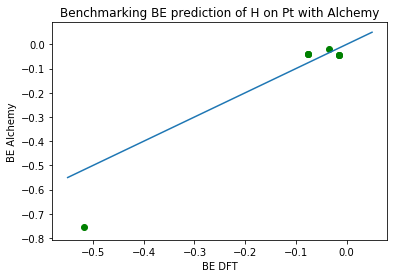

In [70]:
from matplotlib import pyplot as plot
plot.scatter(alc_data['deltaBE_alc'],alc_data['deltaBE_dft'],c='g')
plot.plot([-0.55,0.05],[-0.55,0.05])
plot.title('Benchmarking BE prediction of H on Pt with Alchemy')
plot.xlabel('BE DFT')
plot.ylabel('BE Alchemy')
plot.show()

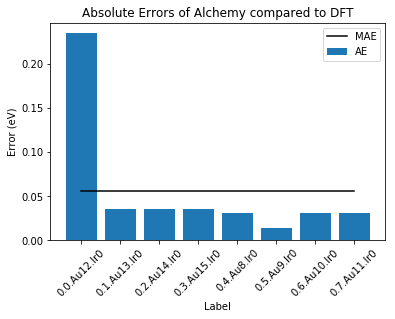

In [83]:
mean_abs_error = np.average(alc_data['absolute errors'])

plot.bar(alc_data['label'],alc_data['absolute errors'])
plot.plot(alc_data['label'],[mean_abs_error]*len(alc_data['label']),'k')
plot.title('Absolute Errors of Alchemy compared to DFT')
plot.xlabel('Label')
plot.ylabel('Error (eV)')
plot.legend(['MAE','AE'])
plot.xticks(rotation=45)
plot.show()

 We can observe from both figures that the errors are small for all but one material. We can visualize this material to see where the transmutations were made.

In [99]:
large_error_system = h_pt_Alc.loc[h_pt_Alc['label'] == '0.0.Au12.Ir0']['ads atoms object']
view(large_error_system)

Upon visualization, we can see that in this system, the transmutation was made at the site directly under the adsorbate. The large error is expected because the magnitude of the alchemical potentials at atoms near the adsorbate typical overestimate the magnitude of the alchemical derivative.